In [23]:
## Import requird packagaes
import numpy as np
import matplotlib.pyplot as plt
import miepython
from tqdm import trange
from astropy.modeling import models
from astropy import units as u
from astropy.io import fits
import pandas as pd
import matplotlib as mpl
from scipy.interpolate import make_interp_spline, interp1d
from matplotlib.collections import LineCollection
import matplotlib.gridspec as gridspec
from scipy import special

# Define quantities
rsun = 6.9634e10
msun = 1.989e33
G = 6.6743e-8


def plot_smooth_colored_line(x, y, colors, num_interp=300, cmap='viridis', linewidth=2, colorbar=True, ax=None,
                            cmap_limits = 'None'):
    '''
    Plots a smooth interpolated line with a color gradient
    
    Parameters:
        x, y       : 1D arrays of coordinates
        colors     : 1D array of values for color mapping (same length as x and y)
        num_interp : number of interpolated points for smoothness
        cmap       : name of the matplotlib colormap
        linewidth  : line width
        colorbar   : whether to show colorbar
        ax         : matplotlib axis to plot on (creates new if None)
    '''
    x, y, colors = np.asarray(x), np.asarray(y), np.asarray(colors)
    
    # Sort by x if needed
    if not np.all(np.diff(x) > 0):
        sort_idx = np.argsort(x)
        x, y, colors = x[sort_idx], y[sort_idx], colors[sort_idx]
        
    select_same = np.array([False]+(np.diff(x)==0).tolist())
    x[select_same] = x[select_same] + np.arange(x.shape[0])[select_same]*1e-20

    # Interpolate x and y
    x_smooth = np.linspace(x.min(), x.max(), num_interp)
    spl = make_interp_spline(x, y, k=3)
    y_smooth = spl(x_smooth)
    
    # Interpolate color values
    color_interp = interp1d(x, colors, kind='linear')
    colors_smooth = color_interp(x_smooth)

    # Create segments for coloring
    points = np.array([x_smooth, y_smooth]).T.reshape(-1, 1, 2)
    segments = np.concatenate([points[:-1], points[1:]], axis=1)

    # LineCollection for color gradient
    if cmap_limits=='None':
        lc = LineCollection(segments, cmap=cmap, norm=plt.Normalize(colors_smooth.min(), colors_smooth.max()))
    else:
        lc = LineCollection(segments, cmap=cmap, norm=plt.Normalize(cmap_limits[0], cmap_limits[1]))
    lc.set_array(colors_smooth)
    lc.set_linewidth(linewidth)

    if ax is None:
        fig, ax = plt.subplots()
    ax.add_collection(lc)

    if colorbar:
        plt.colorbar(lc, ax=ax, label='Color values')
    
    return ax, lc

mpl.rcParams.update(
     {# Use mathtext, not LaTeX
     'text.usetex': False,
     'axes.formatter.use_mathtext': True,
     # Set the fonts
     'font.family': 'STIXGeneral',
     'mathtext.fontset': 'cm',
     # Use ASCII minus
     'axes.unicode_minus': False,
    'axes.linewidth':1.5
})


In [24]:
## Define functions for Mie cross sections

# Extinction cross section
def mie(w,k,r):
    x = 2*np.pi*r/w
    qext, qsca, qback, g = miepython.mie(k, x)
    return qext

# Absorption (emission) cross section
def mie_abs(w,k,r):
    x = 2*np.pi*r/w
    qext, qsca, qback, g = miepython.mie(k, x)
    return (qext - qsca)

## PL particle distribution
def part_dist(r, p):
    return r**(-p)

## Hansen particle distribution 
def part_dist_2(r, reff, veff):
    return r**((1-3*veff)/veff)*np.exp(-r/(reff*veff))

# Mie extinction cross section weighted with PL grain distribution
def mie_part_dist(r,w,k,s):
    pd = part_dist(r, s)
    m = mie(w,k,r)
    return pd*m*np.pi*(r**2)

# Mie extinction cross section weighted with Hansen grain distribution
def mie_part_dist_2(r,w,k,reff, veff):
    p = part_dist_2(r, reff, veff)
    m = mie(w,k,r)
    return p*m*np.pi*(r**2)
    

In [25]:
'''
Setup manual trapezoid integrations as standard python packages misbehaves with complex functions like blacbody
or mie scattering cross sections
'''

# For single integral
def quad(func, var_min, var_max, args, limit = 5000, spacing = 'linear'):
    if not isinstance(args, tuple):
        args = [args]
    if spacing == 'linear':
        grid = np.linspace(var_min, var_max, limit)
    else:
        grid = np.logspace(np.log10(var_min), np.log10(var_max), limit)
    grid_func = func(grid, *args)
    integ = np.trapz(grid_func, grid, axis = 0)
    return [integ, 0]

# For double integral
def integrate_2d(f, x1, x2, y1, y2, args, nx=1000, ny=1000):
    
    if not isinstance(args, tuple):
        args = [args]
    
    x = np.linspace(x1, x2, nx)
    y = np.linspace(y1, y2, ny)
    X, Y = np.meshgrid(x, y, indexing='ij')
    Z = f(X, Y, *args)
    
    dx = (x2 - x1) / (nx - 1)
    dy = (y2 - y1) / (ny - 1)
    
    integral = np.trapz(np.trapz(Z, y, axis=1), x, axis=0)
    return integral

In [26]:
## Define the functions to perform the transit depth calculations

'''
Function to choose vertical structure of disk. Gaussian has been used for the work

z: vertical height as projected on WD surface from the WD misplane
hz: the height of disk (as defined in draft)
z0: any offset (always set to 0 for this work)
'''
def vert_str(z, hz, name = 'gaussian', z0 = 0):
    
    if name=='gaussian':
        
        return np.exp(-((z-z0)/hz)**2)
    
    if name=='power_law':
        
        return np.exp(-abs((z-z0)/hz))
    
'''    
Computes Eq. 12 in draft  

incl: inclination angle in degrees
a: distance to the disk
deltaa: radial width of the disk
'''
def compute_inclined(z, hz, incl, name = 'gaussian', a=100.0, deltaa=10.0):
    
    # convert angle to radian
    irad = incl*np.pi/180.0

    # map the projection z to the height on the disk (Eq 11 in draft)
    h_in_disk = (z/np.sin(irad)) + (a/np.tan(irad))
    
    
    # define the integration limits
    integ_low = h_in_disk - deltaa/(2.0*np.tan(irad))
    integ_high = h_in_disk + deltaa/(2.0*np.tan(irad))
    
    # compute the integration
    #return quad(vert_str, integ_low, integ_high, args=(hz, name, 0.0), limit = 200)[0]/(deltaa*np.cos(irad))
    
    if name=='gaussian':
        return (np.sqrt(np.pi)/2) * (special.erf(integ_high/hz) - special.erf(integ_low/hz))/(deltaa*np.cos(irad))
        
'''    
Computes integrand of Eq. 5 in draft  

z: vertical height as projected on WD surface from the WD misplane (in units of Rwd)
hz: the height of disk (as defined in draft)
lamb: wavelength (in micron)
alpha: the angstrom emponent
'''
def depth_func(z, lamb, tau0, hz, alpha, name='gaussian', z0=0, incl = 'None'):

    intensity_per_aa = bb(lamb * u.micron).value
    
    fact1 = 2.0/np.pi
    fact2 = np.sqrt(1.0 - z**2)
    
    # Reference wavelength is 0.6 angstrom. 
    fact1exp = tau0 * ((lamb/0.6)**(-alpha))
    
    # Condition as compute_inclined becomes undefined at i = 90
    if (incl=='None') or (incl==90.0):
        fact2exp = vert_str(z, hz, name, z0)
    else:
        fact2exp = compute_inclined(z, hz, incl, name)
    
    fact3 = np.exp(-fact1exp * fact2exp)
    
    # Here we return the integrand for numerator of Eq 5
    return fact1*fact2*fact3*intensity_per_aa*lamb

# Just returns B_lambda*lambda: integrand to the denominator of Eq 5
def bb_int(lamb, dummy):
    
    intensity_per_aa = bb(lamb * u.micron).value
    
    return intensity_per_aa*lamb
    

In [27]:
## Define the bandpasses (ZTF g, ATLAS c, ZTF r, ATLAS o, GTC g, GTC r)

band_mean = np.array([0.48, 0.535, 0.635, 0.69])

survey_bandpasses = np.array([[0.42, 0.55],[0.42, 0.65],[0.55, 0.72],[0.55, 0.82], [0.43, 0.48], [0.87, 0.92]])

### Perfectly edge-on case (Section 2.1)

In [28]:
'''
Compute the edge-on case for WD1013 parameters
'''

## Define a blackbody with the WD temperature

quant = u.Quantity(value = 1.0, unit = u.erg / (u.sr * u.cm**2 * u.AA * u.s))
bb = models.BlackBody(temperature=21900 * u.K, scale = quant)

## Choose a range of h_z for the color code
hzs = np.arange(0.1, 2.1, 0.1)

## Choose mid plane optical depths 
tau0s = np.array([0.5, 2.0, 5.0, 500])

## Choose three alpha values
alphas = [1,2,3]

## Initialize arrays
ztfr_depth_all_alphas = []
ztfg_minus_ztfr_all_alphas = []

## Do the computation under loop
for alpha in alphas:
    
    ztfr_depth_all_taus = []
    ztfg_minus_ztfr_all_taus = []

    for tau0 in tau0s:

        ztfg_minus_ztfr = []
        ztfr_depth = []

        for hz in hzs:

            ## Choose ZTF g and calculate the depth
            bp = survey_bandpasses[0]
            depthg = integrate_2d(depth_func, -1.0, 1.0, bp[0], bp[1], args=(tau0, hz, alpha, 'gaussian', 0.0))/quad(bb_int, bp[0], bp[1], args = [1])[0]

            ## Choose ZTF r and calculate the depth
            bp = survey_bandpasses[2]
            depthr = integrate_2d(depth_func, -1.0, 1.0, bp[0], bp[1], args=(tau0, hz, alpha, 'gaussian', 0.0))/quad(bb_int, bp[0], bp[1], args = [1])[0]

            ## Note that the depth given above is the relative flux at the transit
            ## But we want the drop in relative flux
            ## Thus we record 1-value here
            ztfg_minus_ztfr.append(-depthg+depthr)
            ztfr_depth.append(1-depthr)
            
        ztfr_depth_all_taus.append(ztfr_depth)
        ztfg_minus_ztfr_all_taus.append(ztfg_minus_ztfr)
        
    ztfr_depth_all_alphas.append(ztfr_depth_all_taus)
    ztfg_minus_ztfr_all_alphas.append(ztfg_minus_ztfr_all_taus)
    
ztfr_depth_all_alphas = np.array(ztfr_depth_all_alphas)
ztfg_minus_ztfr_all_alphas = np.array(ztfg_minus_ztfr_all_alphas)
    

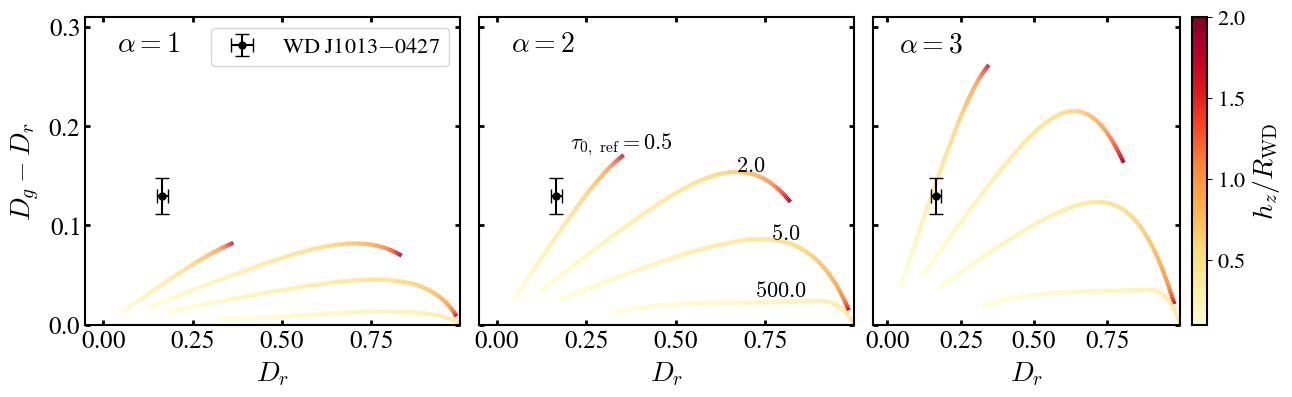

In [29]:
'''
Create Figure 1 in draft
'''

fig = plt.figure(figsize=(15, 4))
gs = gridspec.GridSpec(1, 3, width_ratios=[1, 1, 1], wspace = 0.05)

line_labels = [r'$\tau_{0,~\rm ref}=0.5$', '$2.0$', '$5.0$', '$500.0$']

for i in range(len(alphas)):
    
    ax = fig.add_subplot(gs[0,i])
    
    ax.set_ylim(0,0.31)
    ax.set_xlim(-0.05,0.999)
    
    ax.errorbar(0.166, 0.13, xerr = 0.016, yerr = 0.018, ms=5, marker = 'o', c='k', zorder = 100,
               barsabove = False, ecolor = 'k', capsize = 5, label = r'WD J1013$-$0427', ls = 'None')
    
    ax.text(0.04, 0.275, r'$\alpha={}$'.format(alphas[i]), fontsize = 20)
    
    if i==0:
        
        ax0 = ax
        
        ax.tick_params(axis='x', which='both',direction='in',top=True,right=True,labelsize=18, width=2)
        ax.tick_params(axis='y', which='both',direction='in',top=True,right=True,labelsize=18, width=2)
        
        ax.set_ylabel(r'$D_g-D_r$', fontsize = 20)
        ax.set_xlabel(r'$D_r$', fontsize = 20)
        
    else:
        
        ax.sharex(ax0)
        
        ax.tick_params(axis='x', which='both',direction='in',top=True,right=True,labelsize=18, width=2)
        ax.tick_params(axis='y', which='both',direction='in',top=True,right=True,labelsize=18, width=2,
                       labelleft = False)
        
        ax.set_xlabel(r'$D_r$', fontsize = 20)
    
    for j in range(len(tau0s)):
        
        ztfr_depth = ztfr_depth_all_alphas[i,j,:]
        ztfg_minus_ztfr = ztfg_minus_ztfr_all_alphas[i,j,:]
        
        select = ztfr_depth<1.0
        
        _, lc = plot_smooth_colored_line(ztfr_depth[select], ztfg_minus_ztfr[select], hzs[select], ax=ax, 
                                         colorbar = False, cmap = 'YlOrRd', cmap_limits=[hzs[0], hzs[-1]],
                                        linewidth = 3)
        
        if i==1:
            
            if j==0:
                
                text_xpos = ztfr_depth[np.argmax(ztfg_minus_ztfr)]
                text_ypos = ztfg_minus_ztfr[np.argmax(ztfg_minus_ztfr)]
                ax.text(text_xpos - 0.15, text_ypos + 0.007, line_labels[j], fontsize = 16)
            
            else:
                text_xpos = ztfr_depth[np.argmax(ztfg_minus_ztfr)]
                text_ypos = ztfg_minus_ztfr[np.argmax(ztfg_minus_ztfr)]
                ax.text(text_xpos - (j//3)*0.15, text_ypos + (j//3)*0.005, line_labels[j], fontsize = 16)
        
    if i==2:
        
        cbar = plt.colorbar(lc, ax=ax, pad = 0.03)
        cbar.set_label(r'$h_z/R_{\rm WD}$', fontsize=20)        # Label font size
        cbar.ax.tick_params(labelsize=16) 
        
    if i==0:
        ax.legend(loc='upper right', fontsize = 16)
        
#plt.savefig('./color_depth_space.png', bbox_inches='tight', dpi = 200)
        
plt.show()


### Now with edge-off viewing angles

In [30]:
'''
Calculation for fixed tau_{0,ref}
'''

## Agiain, define a blackbody at temperature of WD1013
quant = u.Quantity(value = 1.0, unit = u.erg / (u.sr * u.cm**2 * u.AA * u.s))
bb = models.BlackBody(temperature=21900 * u.K, scale = quant)

## Take the midplane optical depth and alpha as defined in section 2.1
tau0 = 1000.0
alpha = 3

## Choose the desired inclinations
incls = np.array([90, 89, 88, 87])

## Choose a range of h_zs
hzs = np.arange(0.1, 2.1, 0.1)

ztfg_minus_ztfr_high_tau = []
ztfr_depth_high_tau = []

ztfg_minus_ztfr_high_tau_inclined = []
ztfr_depth_high_tau_inclined = []

## Compute
for incli in trange(len(incls)):
    
    incl = incls[incli]
    
    ztfg_minus_ztfr = []
    ztfr_depth = []


    for hzi in range(len(hzs)):

        hz = hzs[hzi]

        bp = survey_bandpasses[0]
        depthg_incl = integrate_2d(depth_func, -1.0, 1.0, bp[0], bp[1], args=(tau0, hz, alpha, 'gaussian', 0.0, incl))/quad(bb_int, bp[0], bp[1], args = [1])[0]

        bp = survey_bandpasses[2]
        depthr_incl = integrate_2d(depth_func, -1.0, 1.0, bp[0], bp[1], args=(tau0, hz, alpha, 'gaussian', 0.0, incl))/quad(bb_int, bp[0], bp[1], args = [1])[0]

        ztfg_minus_ztfr.append(-depthg_incl+depthr_incl)
        ztfr_depth.append(1-depthr_incl)
        
    ztfr_depth_high_tau_inclined.append(ztfr_depth)
    ztfg_minus_ztfr_high_tau_inclined.append(ztfg_minus_ztfr)
    
ztfr_depth_high_tau_inclined = np.array(ztfr_depth_high_tau_inclined)
ztfg_minus_ztfr_high_tau_inclined = np.array(ztfg_minus_ztfr_high_tau_inclined)
    

100%|█████████████████████████████████████████████| 4/4 [00:09<00:00,  2.33s/it]


In [31]:
'''
Calculation for fixed h_z
'''

quant = u.Quantity(value = 1.0, unit = u.erg / (u.sr * u.cm**2 * u.AA * u.s))
bb = models.BlackBody(temperature=21900 * u.K, scale = quant)

hz = 1.75
alpha = 3.0

taus = np.array([5, 500, 5000])

#incls = np.array([90, 89.75, 89.5, 89.25, 89, 88.75, 88.5, 88.25, 88, 87.75, 87.5, 87.25, 87, 86.75, 86.5, 86.25, 86])
incls = np.arange(90, 85.9, -0.1)

ztfg_minus_ztfr_high_tau = []
ztfr_depth_high_tau = []

ztfg_minus_ztfr_high_hz_inclined = []
ztfr_depth_high_hz_inclined = []

for taui in trange(len(taus)):
    
    tau0 = taus[taui]
    
    ztfg_minus_ztfr = []
    ztfr_depth = []

    for incli in range(len(incls)):

        incl = incls[incli]

        bp = survey_bandpasses[0]
        depthg_incl = integrate_2d(depth_func, -1.0, 1.0, bp[0], bp[1], args=(tau0, hz, alpha, 'gaussian', 0.0, incl))/quad(bb_int, bp[0], bp[1], args = [1])[0]

        bp = survey_bandpasses[2]
        depthr_incl = integrate_2d(depth_func, -1.0, 1.0, bp[0], bp[1], args=(tau0, hz, alpha, 'gaussian', 0.0, incl))/quad(bb_int, bp[0], bp[1], args = [1])[0]

        ztfg_minus_ztfr.append(-depthg_incl+depthr_incl)
        ztfr_depth.append(1-depthr_incl)
        
    ztfr_depth_high_hz_inclined.append(ztfr_depth)
    ztfg_minus_ztfr_high_hz_inclined.append(ztfg_minus_ztfr)
    
ztfr_depth_high_hz_inclined = np.array(ztfr_depth_high_hz_inclined)
ztfg_minus_ztfr_high_hz_inclined = np.array(ztfg_minus_ztfr_high_hz_inclined)
    

100%|█████████████████████████████████████████████| 3/3 [00:14<00:00,  4.89s/it]


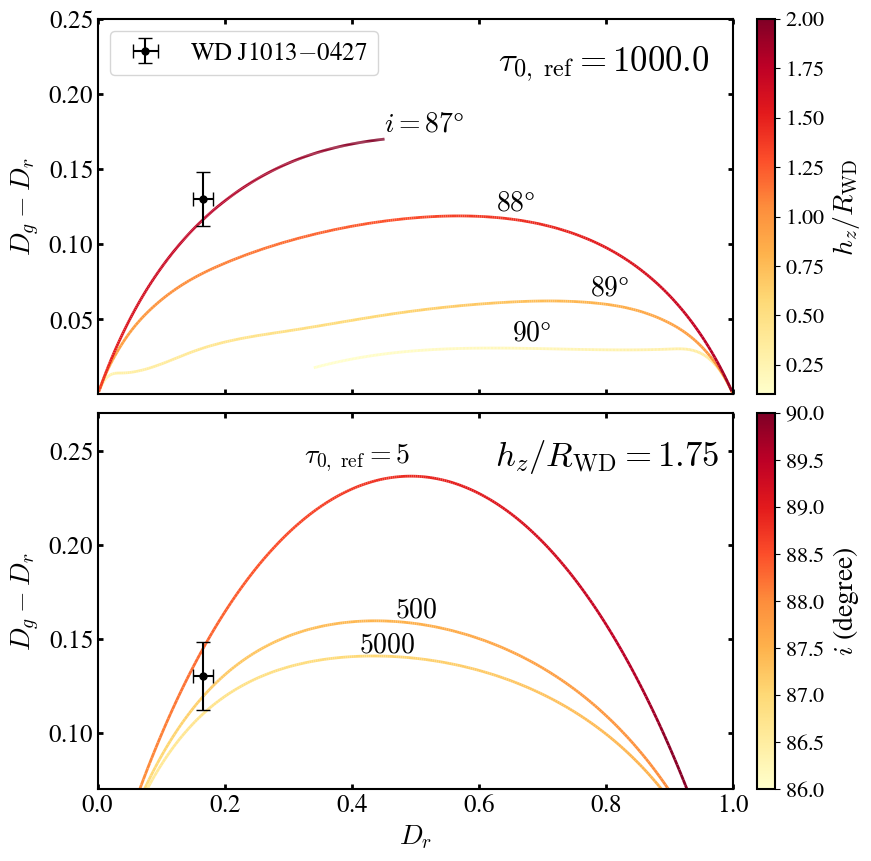

In [32]:
'''
Generate Figure 2 in paper (Figure 7 generated in an identical way)
'''

fig = plt.figure(figsize=(10, 10))
gs = gridspec.GridSpec(2, 1, width_ratios=[1], wspace = 0.05, hspace = 0.05)

################### First Plot #######################

ax = fig.add_subplot(gs[0,0])

incls = np.array([90, 89, 88, 87])

hzs = np.arange(0.1, 2.1, 0.1)

for j in range(len(incls)): 
        
    ztfr_depth = ztfr_depth_high_tau_inclined[j,:]
    ztfg_minus_ztfr = ztfg_minus_ztfr_high_tau_inclined[j,:]
    
    max_index = np.argmax(ztfg_minus_ztfr)
    
    if j==(len(incls)-1):
        ax.text(ztfr_depth[max_index], ztfg_minus_ztfr[max_index]+0.005, r'$i={}\degree$'.format(round(incls[j],2)), fontsize = 20)
    else:
        ax.text(ztfr_depth[max_index], ztfg_minus_ztfr[max_index]+0.005, r'${}\degree$'.format(round(incls[j],2)), fontsize = 20)

    select = ztfr_depth<1.0

    _, lc = plot_smooth_colored_line(ztfr_depth[select], ztfg_minus_ztfr[select], hzs[select], ax=ax, 
                                     colorbar = False, cmap = 'YlOrRd', cmap_limits=[hzs[0], hzs[-1]])
        
    if j==(len(incls)-1):
        
        cbar = plt.colorbar(lc, ax=ax, pad = 0.03)
        cbar.set_label(r'$h_z/R_{\rm WD}$', fontsize=20)        # Label font size
        cbar.ax.tick_params(labelsize=16)
        
ax.set_ylim(0,0.5)

ax.errorbar(0.166, 0.13, xerr = 0.016, yerr = 0.018, ms=5, marker = 'o', c='k', zorder = 100,
               barsabove = False, ecolor = 'k', capsize = 5, label = r'WD J1013$-$0427', ls = 'None')

ax.tick_params(axis='x', which='both',direction='in',top=True,right=True,labelsize=18, width=2,
              labelbottom = False)
ax.tick_params(axis='y', which='both',direction='in',top=True,right=True,labelsize=18, width=2)

ax.set_ylabel(r'$D_g-D_r$', fontsize = 20)

ax.set_ylim(0.0001,0.25)
ax.set_xlim(0.0,1.0)

ax.text(0.63, 0.215, r'$\tau_{0,~\rm ref}=1000.0$', fontsize = 25)

ax.legend(loc='upper left', fontsize=18)

################### Second Plot #######################

ax = fig.add_subplot(gs[1,0])

#incls = np.array([90, 89.75, 89.5, 89.25, 89, 88.75, 88.5, 88.25, 88, 87.75, 87.5, 87.25, 87, 86.75, 86.5, 86.25, 86])
incls = np.arange(90, 85.9, -0.1)

taus = np.array([5, 500, 5000])

for j in range(len(taus)): 
        
    ztfr_depth = ztfr_depth_high_hz_inclined[j,:]
    ztfg_minus_ztfr = ztfg_minus_ztfr_high_hz_inclined[j,:]
    
    max_index = np.argmax(ztfg_minus_ztfr)
    
    if j==0:
        ax.text(ztfr_depth[max_index]-0.2, ztfg_minus_ztfr[max_index]+0.008, r'$\tau_{0,~\rm ref}='+'{}$'.format(round(taus[j],2)), fontsize = 20)
    else:
        ax.text(ztfr_depth[max_index], ztfg_minus_ztfr[max_index]+0.002, r'${}$'.format(round(taus[j],2)), fontsize = 20)

    select = ztfr_depth<1.0

    _, lc = plot_smooth_colored_line(ztfr_depth[select], ztfg_minus_ztfr[select], incls[select], ax=ax, 
                                     colorbar = False, cmap = 'YlOrRd', cmap_limits=[incls[-1], incls[0]])
        
    if j==(len(taus)-1):
        
        cbar = plt.colorbar(lc, ax=ax, pad = 0.03)
        cbar.set_label(r'$i$ (degree)', fontsize=20)        # Label font size
        cbar.ax.tick_params(labelsize=16)
        
ax.set_ylim(0.07,0.27)
ax.set_xlim(0.00,1.0)

ax.errorbar(0.166, 0.13, xerr = 0.016, yerr = 0.018, ms=5, marker = 'o', c='k', zorder = 100,
               barsabove = False, ecolor = 'k', capsize = 5, label = r'WD J1013$-$0427', ls = 'None')

ax.tick_params(axis='x', which='both',direction='in',top=True,right=True,labelsize=18, width=2)
ax.tick_params(axis='y', which='both',direction='in',top=True,right=True,labelsize=18, width=2)

ax.set_ylabel(r'$D_g-D_r$', fontsize = 20)
ax.set_xlabel(r'$D_r$', fontsize = 20)

ax.text(0.625, 0.242, r'$h_{z}/R_{\rm WD}=1.75$', fontsize = 25)

#plt.savefig('./inclination_effect.png', bbox_inches='tight', dpi = 200)
        
plt.show()


### Gray Transitors with $\alpha=0.5$

In [33]:
'''
Calculation for WD1145 (same procedure was used for WD1232)
'''

quant = u.Quantity(value = 1.0, unit = u.erg / (u.sr * u.cm**2 * u.AA * u.s))
bb = models.BlackBody(temperature=15020 * u.K, scale = quant)

hzs = [0.2, 0.5, 1.0, 1.5]
alpha = 0.5

tau0 = 1000.0

#incls = np.array([90, 89.5, 89, 88.5, 88, 87.5, 87, 86.5, 86])
incls = np.arange(90, 85.9, -0.05)

ztfg_minus_ztfr_high_tau = []
ztfr_depth_high_tau = []

ztfg_minus_ztfr_high_hz_inclined = []
ztfr_depth_high_hz_inclined = []


for hzi in trange(len(hzs)):
    
    hz = hzs[hzi]
    
    ztfg_minus_ztfr = []
    ztfr_depth = []

    for incli in range(len(incls)):

        incl = incls[incli]

        bp = survey_bandpasses[4]
        depthg_incl = integrate_2d(depth_func, -1.0, 1.0, bp[0], bp[1], args=(tau0, hz, alpha, 'gaussian', 0.0, incl))/quad(bb_int, bp[0], bp[1], args = [1])[0]

        bp = survey_bandpasses[5]
        depthr_incl = integrate_2d(depth_func, -1.0, 1.0, bp[0], bp[1], args=(tau0, hz, alpha, 'gaussian', 0.0, incl))/quad(bb_int, bp[0], bp[1], args = [1])[0]

        ztfg_minus_ztfr.append(-depthg_incl+depthr_incl)
        ztfr_depth.append(1-depthr_incl)
        
    ztfr_depth_high_hz_inclined.append(ztfr_depth)
    ztfg_minus_ztfr_high_hz_inclined.append(ztfg_minus_ztfr)
    
ztfr_depth_high_hz_inclined = np.array(ztfr_depth_high_hz_inclined)
ztfg_minus_ztfr_high_hz_inclined = np.array(ztfg_minus_ztfr_high_hz_inclined)
    

100%|█████████████████████████████████████████████| 4/4 [00:39<00:00,  9.93s/it]


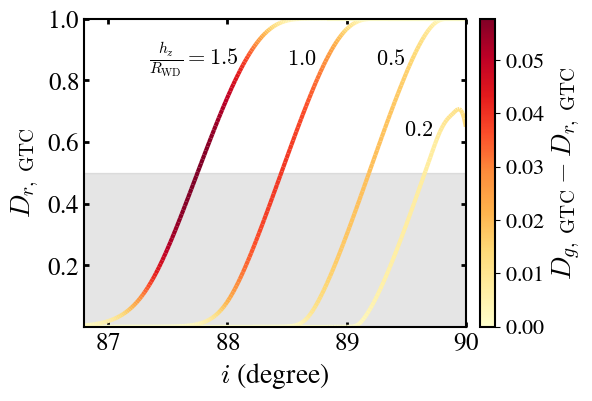

In [36]:
'''
Create Figure 3 in the draft
'''

fig = plt.figure(figsize=(6, 4))
gs = gridspec.GridSpec(1, 1, width_ratios=[1], wspace = 0.05)

ax = fig.add_subplot(gs[0,0])

#incls = np.array([90, 89.5, 89, 88.5, 88, 87.5, 87, 86.5, 86])
incls = np.arange(90, 85.9, -0.05)

text_locs = np.array([89.63, 89.25, 88.50, 87.2])

for j in range(len(hzs)): 
        
    ztfr_depth = ztfr_depth_high_hz_inclined[j,:]
    ztfg_minus_ztfr = ztfg_minus_ztfr_high_hz_inclined[j,:]
    
    max_index = np.argmax(ztfg_minus_ztfr)
    
    if j==3:
    
        ax.text(text_locs[j]+0.14, 0.85, r'$\frac{h_z}{R_{\rm WD}}$'+'$={}$'.format(round(hzs[j],2)), fontsize = 16)
        
    elif j==0:
        
        ax.text(text_locs[j]-0.15, 0.62, r'${}$'.format(round(hzs[j],2)), fontsize = 16)
        
    else:
        
        ax.text(text_locs[j], 0.85, r'${}$'.format(round(hzs[j],2)), fontsize = 16)

    select = ztfr_depth<1.0
        
    _, lc = plot_smooth_colored_line(incls[::-1], ztfr_depth[::-1], ztfg_minus_ztfr[::-1], ax=ax, 
                                     colorbar = False, cmap = 'YlOrRd', 
                cmap_limits=[np.min(ztfg_minus_ztfr_high_hz_inclined), np.max(ztfg_minus_ztfr_high_hz_inclined)],
                                    linewidth = 3)
        
    if j==(0):
        
        cbar = plt.colorbar(lc, ax=ax, pad = 0.03)
        cbar.set_label(r'$D_{g,~\rm GTC}-D_{r,~\rm GTC}$', fontsize=20)        # Label font size
        cbar.ax.tick_params(labelsize=16)
        
ax.set_ylim(0.001,1.0)
ax.set_xlim(86.8,90)

ax.tick_params(axis='x', which='both',direction='in',top=True,right=True,labelsize=18, width=2)
ax.tick_params(axis='y', which='both',direction='in',top=True,right=True,labelsize=18, width=2)

ax.set_ylabel(r'$D_{r,~\rm GTC}$', fontsize = 20)
ax.set_xlabel(r'$i$ (degree)', fontsize = 20)

ax.fill_between(incls, 0, 0.5, color='gray', alpha=0.2)

#plt.savefig('./inclination_effect_colorless_1145.png', bbox_inches='tight', dpi = 200)
        
plt.show()


### Angstrom Exponent

In [4]:
'''
Calculate Angstrom Exponents for the different grain types and size distributions
'''

silicate_ks = [1.7-0.03j, 1.6-0.0001j]

lambdas = np.linspace(0.35,0.90,50)

exps_fits = []

rmaxes = np.logspace(-1.9, 0.69, 40)
    
cols = ['C0', 'C1', 'C2']

pl_curves_silicate = []
pl_curves_silicate_case2 = []
hansen_curves_silicate = []

for ski in range(len(silicate_ks)):
    
    sk = silicate_ks[ski]
    col = cols[ski]
    
    exps_fits = []

    for rmax in rmaxes:
        qmean = []
        for lamb in lambdas:
            ## Calculate Eq 11 for each of the lambdas (rmin = 0.01 micron for PL, see text)
            qmean.append(quad(mie_part_dist, 0.01, rmax, args=(lamb, sk, 3.5), limit=2000, spacing = 'log10')[0]/quad(part_dist, 0.01, rmax, args=(3.5), limit=2000, spacing = 'log10')[0])

        alpha_fit = np.polyfit(np.log10(lambdas), np.log10(qmean), deg = 1)
        exps_fits.append(alpha_fit[0])
        
    pl_curves_silicate.append(exps_fits)
    
    
    exps_fits = []

    for rmax in rmaxes:
        qmean = []
        for lamb in lambdas:
            ## Calculate Eq 11 for each of the lambdas (rmax = 5 micron for PL, see text)
            qmean.append(quad(mie_part_dist, rmax, 5, args=(lamb, sk, 3.5), limit=2000, spacing = 'log10')[0]/quad(part_dist, 0.01, rmax, args=(3.5), limit=2000, spacing = 'log10')[0])

        alpha_fit = np.polyfit(np.log10(lambdas), np.log10(qmean), deg = 1)
        exps_fits.append(alpha_fit[0])
        
    pl_curves_silicate_case2.append(exps_fits)
    
    
    exps_fits = []
    
    for rmax in rmaxes:
        qmean = []
        for lamb in lambdas:
            ## Calculate Eq 11 for each of the lambdas (Hansen, see text)
            qmean.append(quad(mie_part_dist_2, 1e-5, 20.0, args=(lamb, sk, rmax, 0.1), limit=2000, spacing = 'log10')[0]/quad(part_dist_2, 1e-5, 20.0, args=(rmax, 0.1), limit=2000, spacing = 'log10')[0])

        alpha_fit = np.polyfit(np.log10(lambdas), np.log10(qmean), deg = 1)
        exps_fits.append(alpha_fit[0])
        
    hansen_curves_silicate.append(exps_fits)
        

In [5]:
## Load the Iron refractive indices from the two studies

johnson_n = pd.read_csv('Johnson_n.csv')
johnson_k = pd.read_csv('Johnson_k.csv')

werner_n = pd.read_csv('Werner_n.csv')
werner_k = pd.read_csv('Werner_k.csv')


In [6]:
## Do the same calculation for Iron

iron_ks = [[johnson_n, johnson_k], [werner_n, werner_k]]

lambdas = np.linspace(0.35,0.90,50)

qmean = []

exps_fits = []

rmaxes = np.logspace(-1.9, 0.69, 40)
    
cols = ['C0', 'C1', 'C2']

pl_curves_iron = []
pl_curves_iron_case2 = []
hansen_curves_iron = []

for ski in range(len(iron_ks)):
    
    ntable = iron_ks[ski][0]
    ktable = iron_ks[ski][1]
    
    exps_fits = []

    for rmax in rmaxes:
        qmean = []
        for lamb in lambdas:
            
            skn = np.interp(lamb, ntable.wl.values, ntable.n.values)
            skk = np.interp(lamb, ktable.wl.values, ktable.k.values)
            
            sk = complex(skn, -skk)
            
            qmean.append(quad(mie_part_dist, 0.01, rmax, args=(lamb, sk, 3.5), limit=2000, spacing = 'log10')[0]/quad(part_dist, 0.01, rmax, args=(3.5), limit=2000, spacing = 'log10')[0])

        alpha_fit = np.polyfit(np.log10(lambdas), np.log10(qmean), deg = 1)
        exps_fits.append(alpha_fit[0])
        
    pl_curves_iron.append(exps_fits)
    
    
    exps_fits = []

    for rmax in rmaxes:
        qmean = []
        for lamb in lambdas:
            
            skn = np.interp(lamb, ntable.wl.values, ntable.n.values)
            skk = np.interp(lamb, ktable.wl.values, ktable.k.values)
            
            sk = complex(skn, -skk)
            
            qmean.append(quad(mie_part_dist, rmax, 5, args=(lamb, sk, 3.5), limit=2000, spacing = 'log10')[0]/quad(part_dist, 0.01, rmax, args=(3.5), limit=2000, spacing = 'log10')[0])

        alpha_fit = np.polyfit(np.log10(lambdas), np.log10(qmean), deg = 1)
        exps_fits.append(alpha_fit[0])
        
    pl_curves_iron_case2.append(exps_fits)
    
    exps_fits = []
    
    for rmax in rmaxes:
        qmean = []
        for lamb in lambdas:
            
            skn = np.interp(lamb, ntable.wl.values, ntable.n.values)
            skk = np.interp(lamb, ktable.wl.values, ktable.k.values)
            
            sk = complex(skn, -skk)
            
            qmean.append(quad(mie_part_dist_2, 1e-5, 20.0, args=(lamb, sk, rmax, 0.1), limit=2000, spacing = 'log10')[0]/quad(part_dist_2, 1e-5, 20.0, args=(rmax, 0.1), limit=2000, spacing = 'log10')[0])

        alpha_fit = np.polyfit(np.log10(lambdas), np.log10(qmean), deg = 1)
        exps_fits.append(alpha_fit[0])
        
    hansen_curves_iron.append(exps_fits)
            

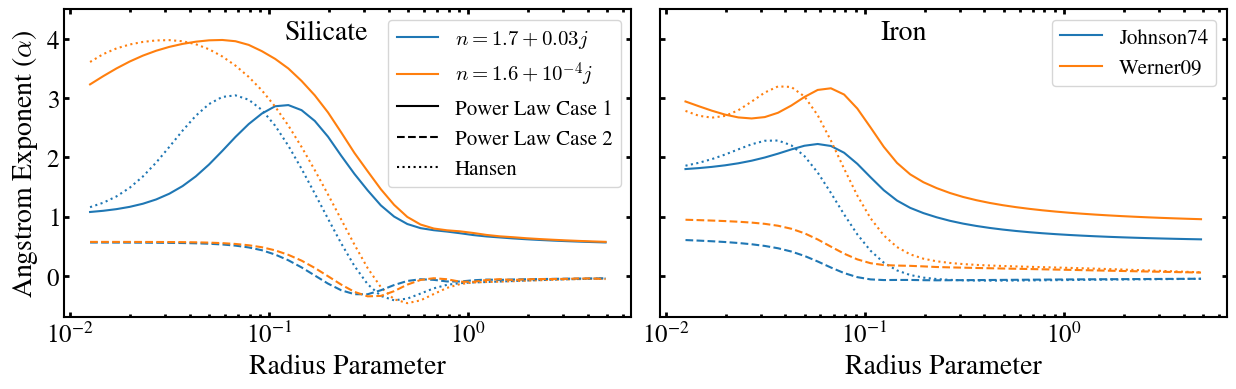

In [7]:
'''
Create Figure 6 in the draft
'''

fig = plt.figure(figsize=(15, 4))
gs = gridspec.GridSpec(1, 2, width_ratios=[1, 1], wspace = 0.05)  # 1 row, 2 columns

ax1 = fig.add_subplot(gs[0])

ax1.plot(rmaxes, -np.array(pl_curves_silicate[0]), c='C0', label = r'$n=1.7+0.03j$')
ax1.plot(rmaxes, -np.array(pl_curves_silicate[1]), c='C1', label = r'$n=1.6+10^{-4}j$')

ax1.plot(rmaxes, -np.array(hansen_curves_silicate[0]), c='C0', linestyle = ':')
ax1.plot(rmaxes, -np.array(hansen_curves_silicate[1]), c='C1', linestyle = ':')

ax1.plot(rmaxes, -np.array(pl_curves_silicate_case2[0]), c='C0', linestyle = '--')
ax1.plot(rmaxes, -np.array(pl_curves_silicate_case2[1]), c='C1', linestyle = '--')

ax1.plot(10, 100, c='k', label = 'Power Law Case 1')
ax1.plot(10, 100, c='k', label = 'Power Law Case 2', linestyle = '--')
ax1.plot(10, 100, c='k', label = 'Hansen', linestyle = ':')

ax2 = fig.add_subplot(gs[1])

ax2.plot(rmaxes, -np.array(pl_curves_iron[0]), c='C0', label = 'Johnson74')
ax2.plot(rmaxes, -np.array(hansen_curves_iron[0]), c='C0', linestyle = ':')
ax2.plot(rmaxes, -np.array(pl_curves_iron_case2[0]), c='C0', linestyle = '--')

ax2.plot(rmaxes, -np.array(pl_curves_iron[1]), c='C1', label = 'Werner09')
ax2.plot(rmaxes, -np.array(hansen_curves_iron[1]), c='C1', linestyle = ':')
ax2.plot(rmaxes, -np.array(pl_curves_iron_case2[1]), c='C1', linestyle = '--')

ax1.set_xscale('log')
ax2.set_xscale('log')

ax1.sharex(ax2)
ax1.sharey(ax2)

ax1.set_ylim(-0.7,4.5)

ax1.legend(fontsize = 15)
ax2.legend(fontsize = 15)

ax1.tick_params(axis='x', which='both',direction='in',top=True,right=True,labelsize=18, width=2)
ax1.tick_params(axis='y', which='both',direction='in',top=True,right=True,labelsize=18, width=2)

ax2.tick_params(axis='x', which='both',direction='in',top=True,right=True,labelsize=18, width=2)
ax2.tick_params(axis='y', which='both',direction='in',top=True,right=True,labelsize=18, width=2, labelleft = False)

ax1.set_xlabel(r'Radius Parameter', fontsize = 20)
ax2.set_xlabel(r'Radius Parameter', fontsize = 20)

ax1.set_ylabel(r'Angstrom Exponent ($\alpha$)', fontsize = 20)

ax1.text(0.12, 4, 'Silicate', fontsize = 20)
ax2.text(0.12, 4, 'Iron', fontsize = 20)

plt.savefig('./angstrom_exponent.png', bbox_inches='tight', dpi = 200)

plt.show()
